In [ ]:
"""

Amazon Product Review NLP Analysis with NER
"""

'\n\nAmazon Product Review NLP Analysis with NER\n'

In [ ]:
# Installation and setups
!pip install -q spacy spacytextblob textblob plotly pandas
!python -m spacy download en_core_web_sm
!python -m textblob.download_corpora

print("✅ Installation complete!")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 136.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 

In [ ]:
# Importing dependencies
# ============================================================================
# CELL 2: IMPORT LIBRARIES
# ============================================================================

# Core NLP library
import spacy

# spaCy extension for sentiment analysis (TextBlob integration)
from spacytextblob.spacytextblob import SpacyTextBlob

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive visualizations
import plotly.express as px
import plotly.graph_objects as go

# For counting word frequencies or entity occurrences
from collections import Counter

# Suppress unnecessary warning messages
import warnings
warnings.filterwarnings('ignore')


In [ ]:
df_full = pd.read_csv(
    "Reviews.csv",
    quotechar='"',
    doublequote=True,
    on_bad_lines='skip',
    engine='python',
    encoding='utf-8'
)


In [ ]:
print(f"\n📊 Dataset Info:")
print(f"  • Total reviews: {len(df_full):,}")
print(f"  • Columns: {list(df_full.columns)}")
print(f"\nFirst few rows:")
print(df_full.head(2))


📊 Dataset Info:
  • Total reviews: 568,454
  • Columns: ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text']

First few rows:
   Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      5  1303862400  Good Quality Dog Food   
1                       0      1  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...  


In [ ]:
# Identify the correct column names
# Try to find review text column
text_col = None
for col in ['reviewText', 'review_text', 'text', 'review', 'Text']:
    if col in df_full.columns:
        text_col = col
        break

In [ ]:
# find rating column
rating_col = None
for col in ['overall', 'rating', 'score', 'Rating', 'Overall', 'Score']:
    if col in df_full.columns:
        rating_col = col
        break

In [ ]:
print(f"\n🎯 Using columns:")
print(f"  • Review text: {text_col}")
print(f"  • Rating: {rating_col}")


🎯 Using columns:
  • Review text: Text
  • Rating: Score


In [ ]:
# Sample data for faster processing (adjust as needed)
SAMPLE_SIZE = 500  # Process 500 reviews for 2-hour sprint
df = df_full.sample(n=min(SAMPLE_SIZE, len(df_full)), random_state=42).copy()

In [ ]:
# Standardize column names
df = df.rename(columns={
    text_col: 'reviewText',
    rating_col: 'rating'
})

In [ ]:
print(df.columns.tolist())
df.head(2)

['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'rating', 'Time', 'Summary', 'reviewText']


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,rating,Time,Summary,reviewText
165256,165257,B000EVG8J2,A1L01D2BD3RKVO,"B. Miller ""pet person""",0,0,5,1268179200,Crunchy & Good Gluten-Free Sandwich Cookies!,Having tried a couple of other brands of glute...
231465,231466,B0000BXJIS,A3U62RE5XZDP0G,Marty,0,0,5,1298937600,great kitty treats,My cat loves these treats. If ever I can't fin...


In [ ]:
# Clean data
df = df.dropna(subset=['reviewText', 'rating'])
df['reviewText'] = df['reviewText'].astype(str)
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df[df['reviewText'].str.len() > 20]  # Remove very short reviews

print(f"\n✅ Processed sample: {len(df)} reviews")
print(f"  • Average review length: {df['reviewText'].str.len().mean():.0f} characters")
print(f"  • Rating distribution:\n{df['rating'].value_counts().sort_index()}")
print(f"\n💡 Processing {len(df)} reviews (adjust SAMPLE_SIZE for more/less)")
print("\nSample reviews:")
print(df[['reviewText', 'rating']].head(3))


✅ Processed sample: 500 reviews
  • Average review length: 446 characters
  • Rating distribution:
rating
1     46
2     28
3     29
4     76
5    321
Name: count, dtype: int64

💡 Processing 500 reviews (adjust SAMPLE_SIZE for more/less)

Sample reviews:
                                               reviewText  rating
165256  Having tried a couple of other brands of glute...       5
231465  My cat loves these treats. If ever I can't fin...       5
427827  A little less than I expected.  It tends to ha...       3


In [ ]:
# INITIALIZE SPACY & NER

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')

print("✅ spaCy model loaded with sentiment analysis!")

✅ spaCy model loaded with sentiment analysis!


In [ ]:
# EXTRACT ENTITIES & SENTIMENT
def extract_products_and_brands(text):
    """Extract product names and brand names from text"""
    doc = nlp(text)

    products = []
    brands = []

    for ent in doc.ents:
        if ent.label_ == 'PRODUCT':
            products.append(ent.text)
        elif ent.label_ == 'ORG':
            # Organizations are often brands
            brands.append(ent.text)

    return products, brands


In [ ]:
def analyze_sentiment(text):
    """Analyze sentiment of text"""
    doc = nlp(text)
    polarity = doc._.blob.polarity  # -1 (negative) to 1 (positive)

    # Classify sentiment
    if polarity > 0.1:
        sentiment = 'Positive'
    elif polarity < -0.1:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    return polarity, sentiment

In [ ]:
# Process all reviews
print("Processing reviews...")
results = []

for idx, row in df.iterrows():
    text = row['reviewText']
    products, brands = extract_products_and_brands(text)
    polarity, sentiment = analyze_sentiment(text)

    results.append({
        'review': text[:100] + '...' if len(text) > 100 else text,
        'rating': row['rating'],
        'products': products,
        'brands': brands,
        'sentiment_score': round(polarity, 3),
        'sentiment': sentiment
    })

Processing reviews...


In [ ]:
results_df = pd.DataFrame(results)
print(f"✅ Processed {len(results_df)} reviews")
print("\n" + "="*80)
print("SAMPLE RESULTS:")
print("="*80)
print(results_df.head(5).to_string())

✅ Processed 500 reviews

SAMPLE RESULTS:
                                                                                                    review  rating products                                            brands  sentiment_score sentiment
0  Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bun...       5       []                                                []            0.319  Positive
1  My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts o...       5       []                                                []            0.435  Positive
2  A little less than I expected.  It tends to have a muddy taste - not what I expected since they said...       3       []                                                []           -0.011   Neutral
3  First there was Frosted Mini-Wheats, in original size, then there was Frosted Mini-Wheats Bite Size....       2       []  [Frosted Mini-Wheats Little Bi

In [ ]:
# ENTITY ANALYSIS
# Extract all products and brands
all_products = []
all_brands = []

for products in results_df['products']:
    all_products.extend(products)

for brands in results_df['brands']:
    all_brands.extend(brands)

# Count occurrences
product_counts = Counter(all_products)
brand_counts = Counter(all_brands)

print("\n" + "="*80)
print("TOP EXTRACTED PRODUCTS:")
print("="*80)
for product, count in product_counts.most_common(10):
    print(f"  • {product}: {count} mentions")

print("\n" + "="*80)
print("TOP EXTRACTED BRANDS:")
print("="*80)
for brand, count in brand_counts.most_common(10):
    print(f"  • {brand}: {count} mentions")


TOP EXTRACTED PRODUCTS:
  • Red Espresso: 2 mentions
  • Byetta: 1 mentions
  • who:<br: 1 mentions
  • Shrimp: 1 mentions
  • Nut Delight: 1 mentions
  • Made: 1 mentions
  • Whiskas Temptation: 1 mentions
  • Convenient: 1 mentions
  • Rottweiler: 1 mentions
  • Jerkys: 1 mentions

TOP EXTRACTED BRANDS:
  • Amazon: 70 mentions
  • MSG: 6 mentions
  • Whole Foods: 4 mentions
  • Senseo: 4 mentions
  • Marley Coffee: 3 mentions
  • LOT: 3 mentions
  • PB2: 3 mentions
  • Starbucks: 2 mentions
  • Stash: 2 mentions
  • FYI: 2 mentions


In [ ]:
#  SENTIMENT ANALYSIS SUMMARY
print("\n" + "="*80)
print("SENTIMENT ANALYSIS SUMMARY:")
print("="*80)

sentiment_dist = results_df['sentiment'].value_counts()
print(f"\n{sentiment_dist}\n")

avg_sentiment = results_df['sentiment_score'].mean()
print(f"Average Sentiment Score: {avg_sentiment:.3f}")
print(f"Sentiment Range: [{results_df['sentiment_score'].min():.3f}, {results_df['sentiment_score'].max():.3f}]")

# Correlation with ratings
correlation = results_df[['rating', 'sentiment_score']].corr().iloc[0, 1]
print(f"\nCorrelation between Rating and Sentiment: {correlation:.3f}")


SENTIMENT ANALYSIS SUMMARY:

sentiment
Positive    385
Neutral      92
Negative     23
Name: count, dtype: int64

Average Sentiment Score: 0.238
Sentiment Range: [-0.781, 1.000]

Correlation between Rating and Sentiment: 0.419


In [ ]:
# VISUALIZATIONS

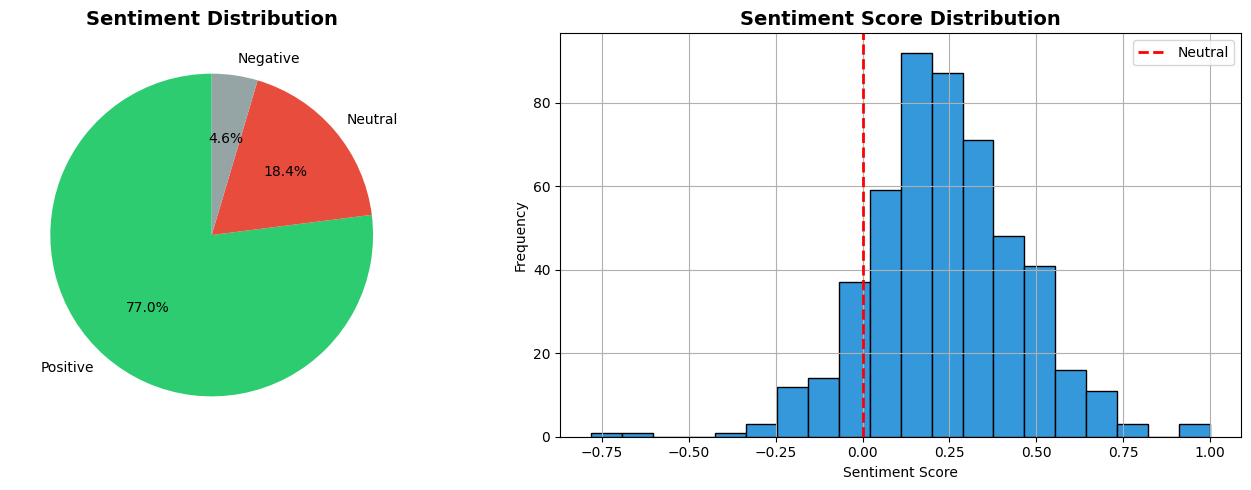

In [ ]:
# Visualization 1: Sentiment Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
sentiment_dist.plot(kind='pie', ax=axes[0], autopct='%1.1f%%', startangle=90,
                    colors=['#2ecc71', '#e74c3c', '#95a5a6'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('')

# Bar chart of sentiment scores
results_df['sentiment_score'].hist(bins=20, ax=axes[1], color='#3498db', edgecolor='black')
axes[1].set_title('Sentiment Score Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment Score')
axes[1].set_ylabel('Frequency')
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Neutral')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Visualizing Top Brands
if brand_counts:
    top_brands = dict(brand_counts.most_common(8))

    fig = px.bar(x=list(top_brands.keys()), y=list(top_brands.values()),
                 title='Top Mentioned Brands',
                 labels={'x': 'Brand', 'y': 'Mentions'},
                 color=list(top_brands.values()),
                 color_continuous_scale='viridis')
    fig.update_layout(showlegend=False, height=400)
    fig.show()

In [ ]:
# Visualization 3: Rating vs Sentiment
fig = px.scatter(results_df, x='rating', y='sentiment_score',
                 color='sentiment',
                 title='Rating vs Sentiment Score',
                 labels={'rating': 'Star Rating', 'sentiment_score': 'Sentiment Score'},
                 color_discrete_map={'Positive': '#2ecc71', 'Negative': '#e74c3c', 'Neutral': '#95a5a6'},
                 height=400)
fig.add_hline(y=0, line_dash="dash", line_color="red")
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# -----------------------------
# Prepare Data
# -----------------------------
top_brands = dict(brand_counts.most_common(8)) if brand_counts else {}
top_products = dict(product_counts.most_common(8)) if product_counts else {}

# -----------------------------
# Create Subplots
# -----------------------------
fig = make_subplots(
    rows=3, cols=2,
    specs=[[{"type": "domain"}, {"type": "xy"}],
           [{"type": "xy"}, {"type": "xy"}],
           [{"colspan": 2, "type": "xy"}, None]],
    subplot_titles=(
        "Sentiment Distribution",
        "Sentiment Score Distribution",
        "Top Mentioned Brands",
        "Top Mentioned Products",
        "Rating vs Sentiment Score"
    )
)

# -----------------------------
# 1. Sentiment Pie Chart
# -----------------------------
fig.add_trace(
    go.Pie(
        labels=sentiment_dist.index,
        values=sentiment_dist.values,
        hole=0.3,
        marker_colors=['#2ecc71', '#95a5a6', '#e74c3c'],
        textinfo='label+percent'
    ),
    row=1, col=1
)

# -----------------------------
# 2. Sentiment Score Histogram
# -----------------------------
fig.add_trace(
    go.Histogram(
        x=results_df['sentiment_score'],
        nbinsx=20,
        marker_color='#3498db',
        name='Sentiment Score'
    ),
    row=1, col=2
)

# Add vertical line for neutral
fig.add_shape(
    go.layout.Shape(
        type="line", x0=0, x1=0,
        y0=0, y1=results_df['sentiment_score'].value_counts().max(),
        line=dict(color="red", dash="dash")
    ),
    row=1, col=2
)

# -----------------------------
# 3. Top Brands Bar Chart
# -----------------------------
if top_brands:
    fig.add_trace(
        go.Bar(
            x=list(top_brands.keys()),
            y=list(top_brands.values()),
            marker_color=list(top_brands.values()),
            name='Brands'
        ),
        row=2, col=1
    )

# -----------------------------
# 4. Top Products Bar Chart
# -----------------------------
if top_products:
    fig.add_trace(
        go.Bar(
            x=list(top_products.keys()),
            y=list(top_products.values()),
            marker_color=list(top_products.values()),
            name='Products'
        ),
        row=2, col=2
    )

# -----------------------------
# 5. Rating vs Sentiment Scatter
# -----------------------------
fig.add_trace(
    go.Scatter(
        x=results_df['rating'],
        y=results_df['sentiment_score'],
        mode='markers',
        marker=dict(
            color=results_df['sentiment'].map({'Positive':'#2ecc71','Neutral':'#95a5a6','Negative':'#e74c3c'}),
            size=8,
            line=dict(width=0.5, color='DarkSlateGrey')
        ),
        name='Rating vs Sentiment'
    ),
    row=3, col=1
)

# -----------------------------
# Layout & Styling
# -----------------------------
fig.update_layout(
    height=1200,
    showlegend=False,
    title_text="📊 Amazon Review Analysis Dashboard",
    title_x=0.5
)

fig.show()


In [ ]:
# DETAILED ENTITY EXAMPLES
print("\n" + "="*80)
print("DETAILED EXAMPLES WITH ENTITIES:")
print("="*80)

for i in range(min(5, len(results_df))):
    row = results_df.iloc[i]
    print(f"\n📝 Review {i+1}:")
    print(f"Text: {row['review']}")
    print(f"Rating: {'⭐' * int(row['rating'])}")
    print(f"Extracted Products: {row['products'] if row['products'] else 'None detected'}")
    print(f"Extracted Brands: {row['brands'] if row['brands'] else 'None detected'}")
    print(f"Sentiment: {row['sentiment']} (Score: {row['sentiment_score']})")
    print("-" * 80)


DETAILED EXAMPLES WITH ENTITIES:

📝 Review 1:
Text: Having tried a couple of other brands of gluten-free sandwich cookies, these are the best of the bun...
Rating: ⭐⭐⭐⭐⭐
Extracted Products: None detected
Extracted Brands: None detected
Sentiment: Positive (Score: 0.319)
--------------------------------------------------------------------------------

📝 Review 2:
Text: My cat loves these treats. If ever I can't find her in the house, I just pop the top and she bolts o...
Rating: ⭐⭐⭐⭐⭐
Extracted Products: None detected
Extracted Brands: None detected
Sentiment: Positive (Score: 0.435)
--------------------------------------------------------------------------------

📝 Review 3:
Text: A little less than I expected.  It tends to have a muddy taste - not what I expected since they said...
Rating: ⭐⭐⭐
Extracted Products: None detected
Extracted Brands: None detected
Sentiment: Neutral (Score: -0.011)
--------------------------------------------------------------------------------

📝 Review 4

In [ ]:
# BRAND SENTIMENT ANALYSIS
# Create brand-sentiment mapping
brand_sentiments = {}

for idx, row in results_df.iterrows():
    for brand in row['brands']:
        if brand not in brand_sentiments:
            brand_sentiments[brand] = []
        brand_sentiments[brand].append(row['sentiment_score'])

# Calculate average sentiment per brand
brand_avg_sentiment = {brand: np.mean(scores)
                       for brand, scores in brand_sentiments.items()
                       if len(scores) > 0}

if brand_avg_sentiment:
    brand_sentiment_df = pd.DataFrame(
        list(brand_avg_sentiment.items()),
        columns=['Brand', 'Avg_Sentiment']
    ).sort_values('Avg_Sentiment', ascending=False)

    print("\n" + "="*80)
    print("BRAND SENTIMENT RANKINGS:")
    print("="*80)
    print(brand_sentiment_df.to_string(index=False))


BRAND SENTIMENT RANKINGS:
                                      Brand  Avg_Sentiment
                                       SAMU       0.625000
                                    Walmart       0.575000
                    Cadburys Milk Chocolate       0.531000
                                beetlejuice       0.525000
                                  Northwest       0.524000
                                     Kettle       0.518000
                                  Pineapple       0.500000
                                 amazon.com       0.486000
                    Cracovia Herring Filets       0.486000
                                  Subscribe       0.474000
                       the Amazon Subscribe       0.474000
                                        OMG       0.465000
                                     McCann       0.450000
                               Blue Diamond       0.440000
                            Starbucks House       0.427000
                             

In [ ]:
# Visualization
if brand_avg_sentiment:
    fig = px.bar(brand_sentiment_df, x='Brand', y='Avg_Sentiment',
                 title='Average Sentiment by Brand',
                 color='Avg_Sentiment',
                 color_continuous_scale=['red', 'yellow', 'green'],
                 height=400)
    fig.add_hline(y=0, line_dash="dash", line_color="black")
    fig.show()

In [ ]:
#Average Sentiment by Brand
if brand_avg_sentiment:
    fig = px.bar(
        brand_sentiment_df,
        x='Brand',
        y='Avg_Sentiment',
        title='Average Sentiment by Brand',
        color='Avg_Sentiment',
        color_continuous_scale=['red', 'yellow', 'green'],
        text=[f"{v:.2f}" for v in brand_sentiment_df['Avg_Sentiment']],
        height=400
    )
    fig.update_traces(textposition='outside')
    fig.add_hline(y=0, line_dash="dash", line_color="black")
    fig.show()


In [ ]:
# Average Sentiment by Product
if product_avg_sentiment:
    top_product_sentiment = pd.DataFrame(
        list(product_avg_sentiment.items()), columns=['Product', 'Avg_Sentiment']
    ).sort_values('Avg_Sentiment', ascending=False).head(8)

    fig = px.bar(
        top_product_sentiment,
        x='Product',
        y='Avg_Sentiment',
        title='Average Sentiment by Product',
        color='Avg_Sentiment',
        color_continuous_scale=['red', 'yellow', 'green'],
        text=[f"{v:.2f}" for v in top_product_sentiment['Avg_Sentiment']],
        height=400
    )
    fig.update_traces(textposition='outside')
    fig.add_hline(y=0, line_dash="dash", line_color="black")
    fig.show()


In [ ]:
# PRODUCT SENTIMENT ANALYSIS
# Create product-sentiment mapping
product_sentiments = {}

for idx, row in results_df.iterrows():
    for product in row['products']:
        if product not in product_sentiments:
            product_sentiments[product] = []
        product_sentiments[product].append(row['sentiment_score'])

# Calculate average sentiment per product
product_avg_sentiment = {product: np.mean(scores)
                         for product, scores in product_sentiments.items()
                         if len(scores) > 0}

if product_avg_sentiment:
    product_sentiment_df = pd.DataFrame(
        list(product_avg_sentiment.items()),
        columns=['Product', 'Avg_Sentiment']
    ).sort_values('Avg_Sentiment', ascending=False)

    print("\n" + "="*80)
    print("PRODUCT SENTIMENT RANKINGS:")
    print("="*80)
    print(product_sentiment_df.to_string(index=False))


PRODUCT SENTIMENT RANKINGS:
           Product  Avg_Sentiment
            Byetta          0.518
            Shrimp          0.380
       Nut Delight          0.360
  the Power Crunch          0.335
        grape soda          0.296
            Jerkys          0.254
              Made          0.233
Whiskas Temptation          0.200
      Red Espresso          0.197
         Green Tea          0.186
           who:<br          0.159
         Subscribe          0.133
        Convenient          0.116
       Cytomax.<br          0.079
          Gatorade          0.079
       Aspergillus         -0.051
        Rottweiler         -0.200


In [ ]:
# EXPORT RESULTS
# Save to CSV
results_df.to_csv('nlp_analysis_results.csv', index=False)

In [ ]:
# Create summary report
summary = f"""
AMAZON PRODUCT REVIEW NLP ANALYSIS - SUMMARY REPORT
{'='*70}

DATASET STATISTICS:
  • Total Reviews Analyzed: {len(results_df)}
  • Total Products Detected: {len(all_products)}
  • Total Brands Detected: {len(all_brands)}
  • Unique Products: {len(product_counts)}
  • Unique Brands: {len(brand_counts)}

SENTIMENT ANALYSIS:
  • Positive Reviews: {sentiment_dist.get('Positive', 0)} ({sentiment_dist.get('Positive', 0)/len(results_df)*100:.1f}%)
  • Negative Reviews: {sentiment_dist.get('Negative', 0)} ({sentiment_dist.get('Negative', 0)/len(results_df)*100:.1f}%)
  • Neutral Reviews: {sentiment_dist.get('Neutral', 0)} ({sentiment_dist.get('Neutral', 0)/len(results_df)*100:.1f}%)
  • Average Sentiment Score: {avg_sentiment:.3f}
  • Sentiment-Rating Correlation: {correlation:.3f}

TOP 5 BRANDS:
{chr(10).join([f"  {i+1}. {brand} ({count} mentions)" for i, (brand, count) in enumerate(list(brand_counts.most_common(5)))])}

TOP 5 PRODUCTS:
{chr(10).join([f"  {i+1}. {product} ({count} mentions)" for i, (product, count) in enumerate(list(product_counts.most_common(5)))])}
"""

print(summary)


AMAZON PRODUCT REVIEW NLP ANALYSIS - SUMMARY REPORT

DATASET STATISTICS:
  • Total Reviews Analyzed: 500
  • Total Products Detected: 18
  • Total Brands Detected: 326
  • Unique Products: 17
  • Unique Brands: 217

SENTIMENT ANALYSIS:
  • Positive Reviews: 385 (77.0%)
  • Negative Reviews: 23 (4.6%)
  • Neutral Reviews: 92 (18.4%)
  • Average Sentiment Score: 0.238
  • Sentiment-Rating Correlation: 0.419

TOP 5 BRANDS:
  1. Amazon (70 mentions)
  2. MSG (6 mentions)
  3. Whole Foods (4 mentions)
  4. Senseo (4 mentions)
  5. Marley Coffee (3 mentions)

TOP 5 PRODUCTS:
  1. Red Espresso (2 mentions)
  2. Byetta (1 mentions)
  3. who:<br (1 mentions)
  4. Shrimp (1 mentions)
  5. Nut Delight (1 mentions)



In [ ]:
# Save summary
with open('analysis_summary.txt', 'w') as f:
    f.write(summary)

print("\n✅ Results exported!")
print("  • nlp_analysis_results.csv")
print("  • analysis_summary.txt")


✅ Results exported!
  • nlp_analysis_results.csv
  • analysis_summary.txt


In [ ]:
from google.colab import files

print("\n📥 Downloading results...")
files.download('nlp_analysis_results.csv')
files.download('analysis_summary.txt')



📥 Downloading results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>